# Geospatial application of toprock random forest library

This notebook is an example of applying the geospatial random forest library to a new csv dataset.

A test dataset is provided in this repo consisting of terrain derivatives across a square spatial extent
	- in this case, these were prior calculated from a digital elevation model using [GRASS GIS](https://grass.osgeo.org/)
* In addition to the x,y position and the derivative values themselves, is a column called `rock_presence`
	- 1 means that a exposed bedrock was observed at that location
	- 0 means that a exposed bedrock was not observed at that location
* The model example here is being trained to predict rock presence/absence based on the `rock_presence` column, considering the derivatives provided
* For this example, an 80:20 test:train split is used (refer to the comments below)

---
**Software setup**

Before proceeding, ensure you're environment is correctly set-up.

Refer to the set-up documentation provided at the top level of this repo.

In [1]:
#%matplotlib notebook 
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import preprocessing
import h2o
import random
import logging
import seaborn as sn

# from the relative path
sys.path.append('../..') # this enables to access other scripts in the ML repo - this is a relative path from our current position to: `geospatial-random-forest/`
from rf_classifier import data_processing, h2o_rf, plotting
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics



---
**Input data** 

Now define the location of some data - we're using some that have been uploaded to this directory.

For this example, we're using data from the rock@surface project (stored here: /drives/w/teams/NGM/NGM_ShallowSubsurface/Data/TopRock/RockAtSurface/TOPROCK_M-and-V-RESULTS/raw_data/)

On the VM via MobaXterm, you can drag and drop files into the folder structure.

In [2]:
# Set data path
TEST_DATA = "./example_data/sample_derivatives.csv"
# Read in data and process
features = pd.read_csv(TEST_DATA, encoding="ISO-8859-1", na_values=['NA',-9999], low_memory=False)


In [3]:
# Look at the column features
print(features.columns)
# Look at the values of the `rock_presence` column
print(features.rock_presence.unique())

Index(['x', 'y', 'rock_presence', 'elevation', 'conv_k3', 'mrrtf_t42',
       'mrvbf_t42', 'aspect', 'easterness', 'fishersK_k3', 'fishersK_k5',
       'fishersK_k7', 'fishersK_k9', 'geomorphons', 'grass_aspect',
       'grass_pcurve', 'grass_slope', 'grass_tcurve', 'northerness',
       'northerness_slope', 'slope', 'stdDev_k3', 'stdDev_k5', 'stdDev_k7',
       'stdDev_k9', 'topoRoughIdx_k3', 'topoRoughIdx_k5', 'topoRoughIdx_k7',
       'topoRoughIdx_k9', 'topoWetIdx', 'vector_strength_k3',
       'vector_strength_k5', 'vector_strength_k7', 'vector_strength_k9'],
      dtype='object')
[0. 1.]


---

**Define model input parameters**

Now define various model parameters including info on the dataset you are providing.

The settings here are the same as those used by A. Hall for rock@surface

In [4]:
random.seed(57) # python random number generators need a value from which to start randomising...

TEST_PROP=0.20 #proportion of data held out for testing -- 0.20 = 20 % etc.

DEPENDENT_COLUMN ='rock_presence' #name of column that holds the presence/absence info - for rock@surface, this was called "Class"
POS_VALUE = '1'
NEG_VALUE = '0'

RESCALE_DATA = False #doesnt matter for RF but helps with scatterplots and data validation
ONE_HOT_ENCODE = False #not needed if using mixed type model
TEST_SCALE_METHOD = 'none' #'upsample', 'downsample' or 'none'
TRAIN_SCALE_METHOD = 'upsample' #'upsample', 'downsample' or 'none'

#DROPS = ['grass_aspect'] #columns to drop entirely
DROPS = [] #columns to drop entirely
COMPLETE_VARIABLES = ['elevation', 'conv_k3', 'mrrtf_t42',
       'mrvbf_t42', 'easterness', 'fishersK_k3', 'fishersK_k5',
       'fishersK_k7', 'fishersK_k9', 'geomorphons', 'grass_pcurve', 'grass_slope', 'grass_tcurve', 'northerness',
       'northerness_slope', 'slope', 'stdDev_k3', 'stdDev_k5', 'stdDev_k7',
       'stdDev_k9', 'topoRoughIdx_k3', 'topoRoughIdx_k5', 'topoRoughIdx_k7',
       'topoRoughIdx_k9', 'topoWetIdx', 'vector_strength_k3',
       'vector_strength_k5', 'vector_strength_k7', 'vector_strength_k9'] #features that cannot be na (nas in these columns result in dropped rows)
DIRECTIONAL_VARIABLES = ['aspect', 'grass_aspect'] # list of variables defined as compass degrees - the be retyped as categoricals
NON_NUMERIC_VARIABLES = []
TRAIN_DATA_DROPS = ['x','y'] #variables to be used for plotting but not for model training (ie coordinates)
SPATIAL_VARIABLES = ['x','y']
X_COL = SPATIAL_VARIABLES[0]
Y_COL = SPATIAL_VARIABLES[1]

MODEL_OPATH = "RFClassifier_h2o" #directory where the model is saved


RF_PARAMS = {"ntrees": 500,
             "max_depth": 50, 
             "min_rows": 20,
             "mtries": -1, #default - samples sqrt number of columns (-1)
             "calibrate_model": False,
             "binomial_double_trees": True,#essentially doubles tree count
             "balance_classes": False, #weight predictions in order to compensate for class imbalance
             "histogram_type": "Random" #use extrememly randomized trees (remove argument to change)
             }


Data clean up...

In [5]:
#drop any columns as defined above
if len(DROPS)>0:
    features.drop(DROPS, axis=1, inplace = True)

#drop rows with na
features.dropna(subset = COMPLETE_VARIABLES, inplace = True)

##replace dependent labels with 1/0
#features[DEPENDENT_COLUMN] = features[DEPENDENT_COLUMN].replace({POS_VALUE: 1, NEG_VALUE:0})

#drop rows with non alphanumeric values
numeric_columns = features.columns[~features.columns.isin(NON_NUMERIC_VARIABLES + [DEPENDENT_COLUMN] + TRAIN_DATA_DROPS)]
features[numeric_columns] = features[numeric_columns].replace('[^0-9\-\.]','', regex=True)
features[SPATIAL_VARIABLES] = features[SPATIAL_VARIABLES].apply(pd.to_numeric, errors='coerce')


my_nans=data_processing.get_rows_with_nans(features)

# Convert appropriate columns to numeric
features[numeric_columns] = features[numeric_columns].apply(pd.to_numeric)

#features = data_processing.drop_invalid_results(features, DEPENDENT_COLUMN)

# Convert nans to zero - now valid as unsuitable nas were dropped
features.fillna(value=0,inplace=True)

# Apply this to dataset
features_original=features # keep for later - not hot-encoded

# Double check remaining columns
print(features.columns)
   

Index(['x', 'y', 'rock_presence', 'elevation', 'conv_k3', 'mrrtf_t42',
       'mrvbf_t42', 'aspect', 'easterness', 'fishersK_k3', 'fishersK_k5',
       'fishersK_k7', 'fishersK_k9', 'geomorphons', 'grass_aspect',
       'grass_pcurve', 'grass_slope', 'grass_tcurve', 'northerness',
       'northerness_slope', 'slope', 'stdDev_k3', 'stdDev_k5', 'stdDev_k7',
       'stdDev_k9', 'topoRoughIdx_k3', 'topoRoughIdx_k5', 'topoRoughIdx_k7',
       'topoRoughIdx_k9', 'topoWetIdx', 'vector_strength_k3',
       'vector_strength_k5', 'vector_strength_k7', 'vector_strength_k9'],
      dtype='object')


Where we have directional variables (e.g. aspect which is valued from 0-360), we need to deal with these such that they are converted categorical values (i.e. N, S, E, W etc.). 

To do this, we'll use a custom function from our custom `data_processing` module which we imported earlier from the `../../rf_classifier` folder

In [6]:
# Retype compass point variables
for f in DIRECTIONAL_VARIABLES:   
    try:
        features[f]=data_processing.categorize_aspect(features[f])
        
    except:
        print("check directional variables are entered correctly")
        #logging.info("check directional variables are entered correctly")
        
print(features[DIRECTIONAL_VARIABLES])        


      aspect grass_aspect
0         NW           NW
1         SW            W
2          W            W
3         NW            W
4          W           NW
...      ...          ...
20861     SW           SW
20862      S            S
20863      W           SW
20864     SW           SW
20865     SW           SW

[20866 rows x 2 columns]


We can also hot encode variables if this was defined during the model setup stage - more on one hot encoding here: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [7]:
if(ONE_HOT_ENCODE):
    features = pd.get_dummies(features)
    # Display the first 5 rows of the last 12 columns
    #print(features.iloc[:,5:].head(5))
    print('The shape of our features before hot-encoding is:', features_original.shape)
    print('The shape of our features after hot-encoding is:', features.shape)

Final check no NaNs...

In [8]:
# Drop any rows with NA
while features.isnull().values.any():
    features.dropna(inplace = True)

if not features.isnull().values.any():
    print("No NaNs in dataframe")

No NaNs in dataframe


---
**Pre-model data interrogation**

Have a quick look at how the variables we're going to use as input relate to one another...

C:\Users\chrwil\AppData\Local\Temp\ipykernel_12532\4214816076.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = features.corr()


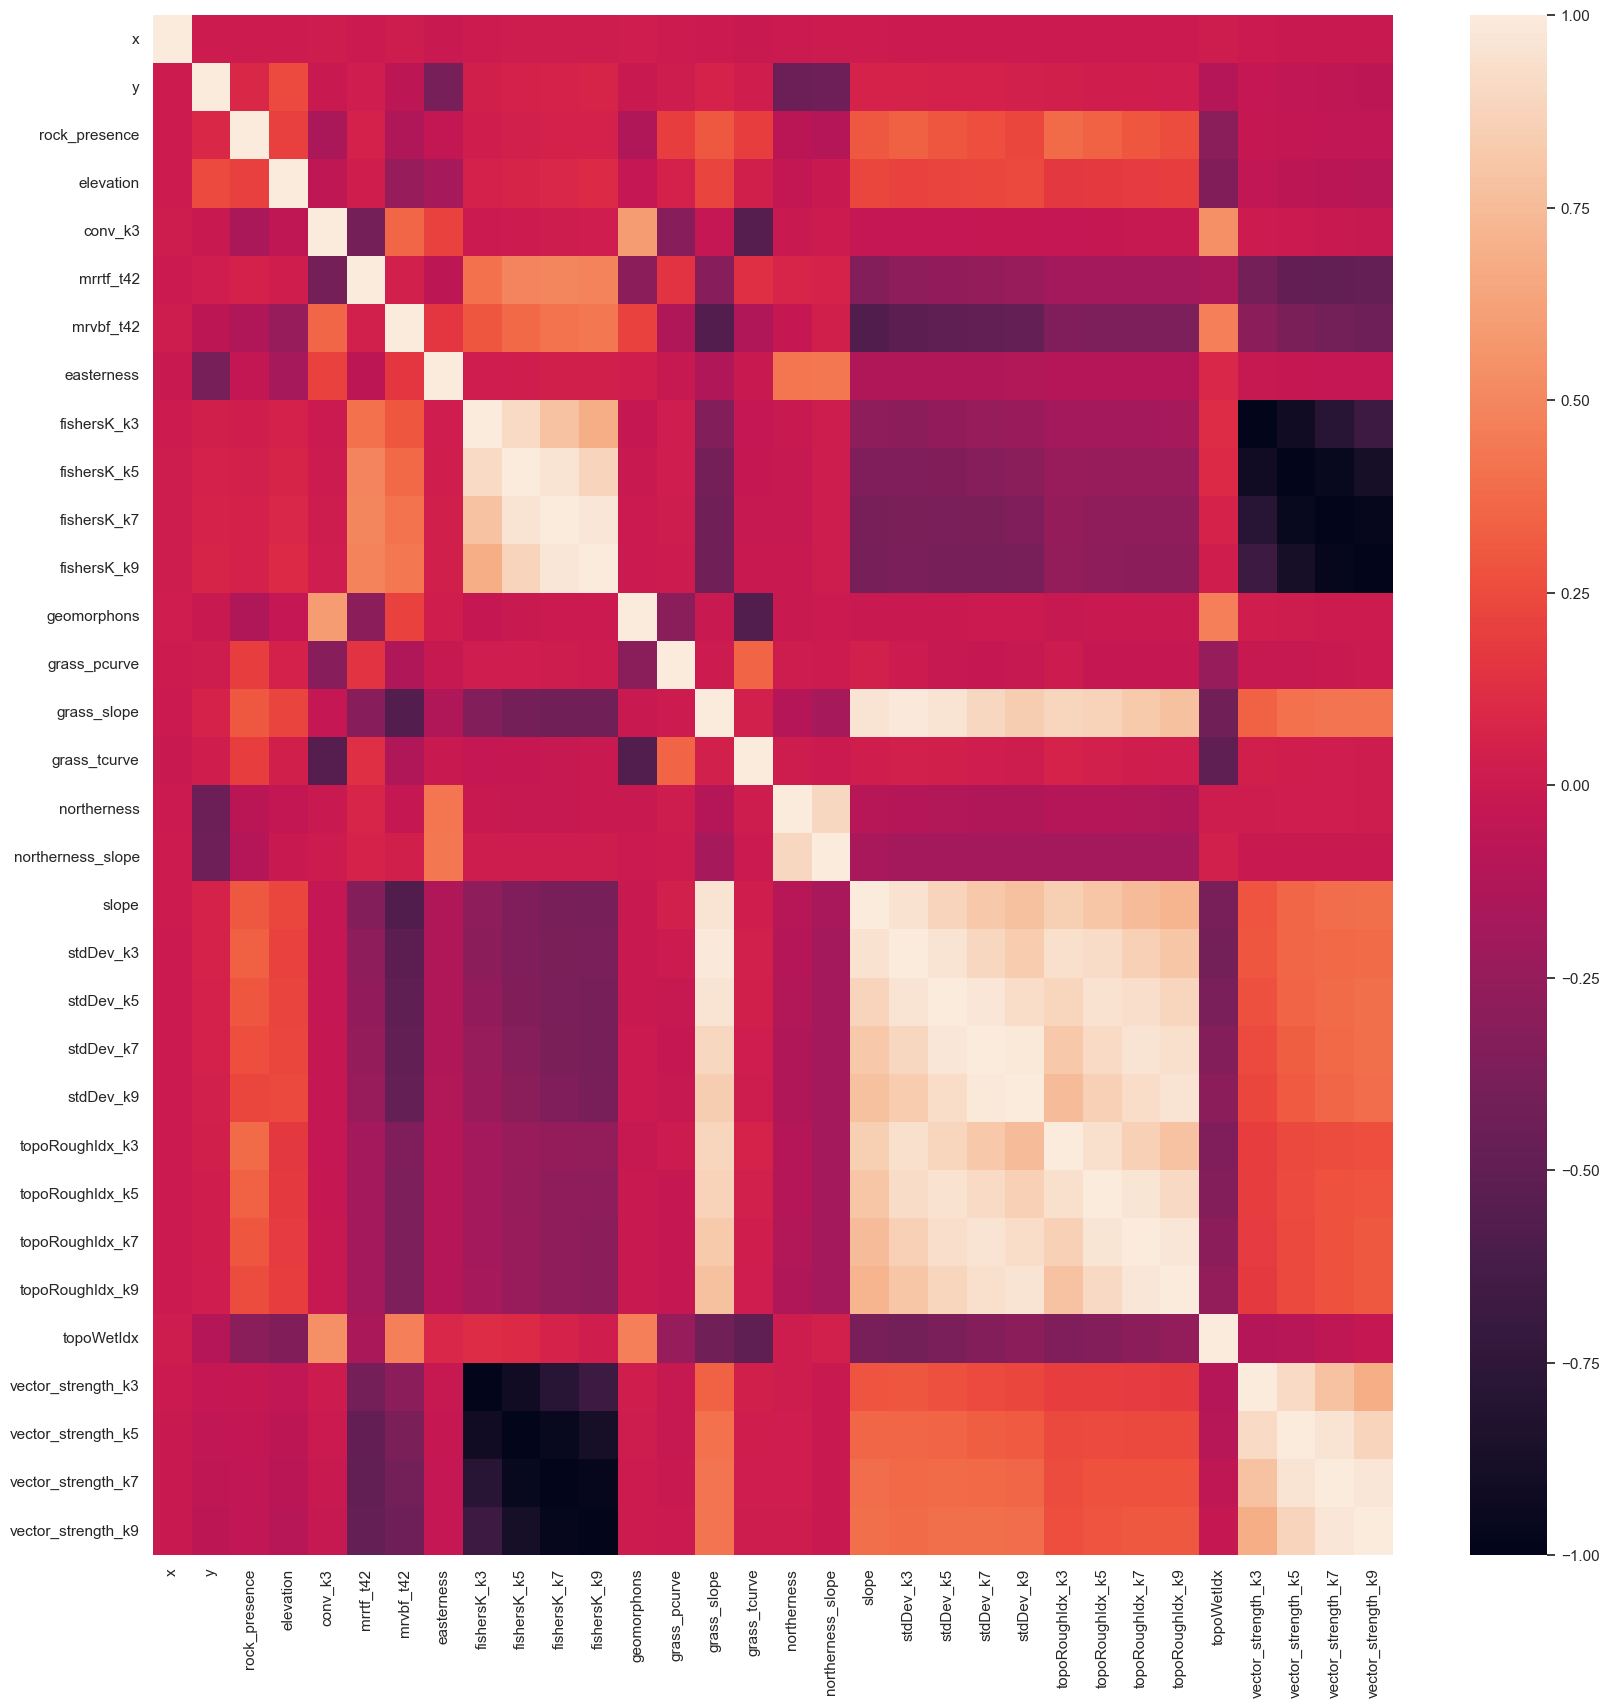

In [9]:
#correlation matrix
cm = features.corr()
sn.set(rc={'figure.figsize':(20,20)})
sn.heatmap(cm, annot=False)
pd.options.display.max_rows = 4000

... and a quick eyeball of the data to check nothing untoward is present

In [10]:
pd.options.display.max_columns = 4000
cm


x         y  rock_presence  elevation   conv_k3  \
x                   1.000000  0.000219       0.005964   0.006253  0.012518   
y                   0.000219  1.000000       0.091131   0.247755 -0.012769   
rock_presence       0.005964  0.091131       1.000000   0.202220 -0.160261   
elevation           0.006253  0.247755       0.202220   1.000000 -0.060063   
conv_k3             0.012518 -0.012769      -0.160261  -0.060063  1.000000   
mrrtf_t42          -0.002780  0.021684       0.048727   0.029401 -0.402374   
mrvbf_t42           0.008895 -0.065481      -0.130852  -0.246221  0.354846   
easterness         -0.013814 -0.392430      -0.043862  -0.177258  0.211653   
fishersK_k3         0.003983  0.031369       0.029090   0.050095 -0.006425   
fishersK_k5         0.011367  0.048400       0.041648   0.068811  0.002136   
fishersK_k7         0.013977  0.060405       0.048277   0.084336  0.012812   
fishersK_k9         0.013800  0.069167       0.051027   0.095700  0.019047   
geomorphons         0.021587 -0.012039      -0.134825  -0.033765  0.599252   
grass_pcurve        0.003154  0.008426       0.194497   0.048120 -0.317115   
grass_slope        -0.003343  0.059603       0.302800   0.224107 -0.036565   
grass_tcurve       -0.010356  0.024245       0.191433   0.031504 -0.550711   
northerness        -0.001921 -0.449423      -0.082285  -0.044678 -0.011921   
northerness_slope   0.002070 -0.431319      -0.104730  -0.013883  0.006455   
slope               0.000316  0.060235       0.297864   0.229143 -0.038627   
stdDev_k3          -0.002157  0.055040       0.333066   0.217653 -0.036859   
stdDev_k5          -0.003798  0.052499       0.296015   0.226413 -0.032971   
stdDev_k7          -0.005183  0.049218       0.258049   0.232681 -0.028930   
stdDev_k9          -0.003436  0.044577       0.230031   0.234660 -0.024971   
topoRoughIdx_k3    -0.000093  0.035130       0.378840   0.171044 -0.036373   
topoRoughIdx_k5    -0.002776  0.030477       0.337645   0.179600 -0.028865   
topoRoughIdx_k7    -0.005006  0.025784       0.289936   0.185728 -0.022628   
topoRoughIdx_k9    -0.003443  0.020054       0.253974   0.187621 -0.019131   
topoWetIdx          0.010738 -0.107684      -0.306892  -0.346443  0.534466   
vector_strength_k3 -0.003983 -0.031369      -0.029090  -0.050095  0.006425   
vector_strength_k5 -0.011367 -0.048400      -0.041648  -0.068811 -0.002136   
vector_strength_k7 -0.013977 -0.060405      -0.048277  -0.084336 -0.012812   
vector_strength_k9 -0.013800 -0.069167      -0.051027  -0.095700 -0.019047   

                    mrrtf_t42  mrvbf_t42  easterness  fishersK_k3  \
x                   -0.002780   0.008895   -0.013814     0.003983   
y                    0.021684  -0.065481   -0.392430     0.031369   
rock_presence        0.048727  -0.130852   -0.043862     0.029090   
elevation            0.029401  -0.246221   -0.177258     0.050095   
conv_k3             -0.402374   0.354846    0.211653    -0.006425   
mrrtf_t42            1.000000   0.046148   -0.067072     0.399967   
mrvbf_t42            0.046148   1.000000    0.156736     0.295372   
easterness          -0.067072   0.156736    1.000000     0.018478   
fishersK_k3          0.399967   0.295372    0.018478     1.000000   
fishersK_k5          0.485347   0.371498    0.026919     0.907887   
fishersK_k7          0.499155   0.411481    0.032517     0.787511   
fishersK_k9          0.481023   0.433573    0.035169     0.687263   
geomorphons         -0.291368   0.213824    0.024268    -0.024252   
grass_pcurve         0.147591  -0.130384   -0.017085     0.021956   
grass_slope         -0.314982  -0.565211   -0.133230    -0.337804   
grass_tcurve         0.127968  -0.134161   -0.012825    -0.035884   
northerness          0.073305  -0.024820    0.422725    -0.014951   
northerness_slope    0.055278   0.035851    0.432236     0.010238   
slope               -0.329152  -0.583435   -0.132580    -0.285364   
stdDev_k3           -0.286102  -0.520344   -0.131219    -0.295156   
std

Can continue plotting now using pandas/seaborn functionality...

`sns.pairplot` is ideal for looking at interrelationships 

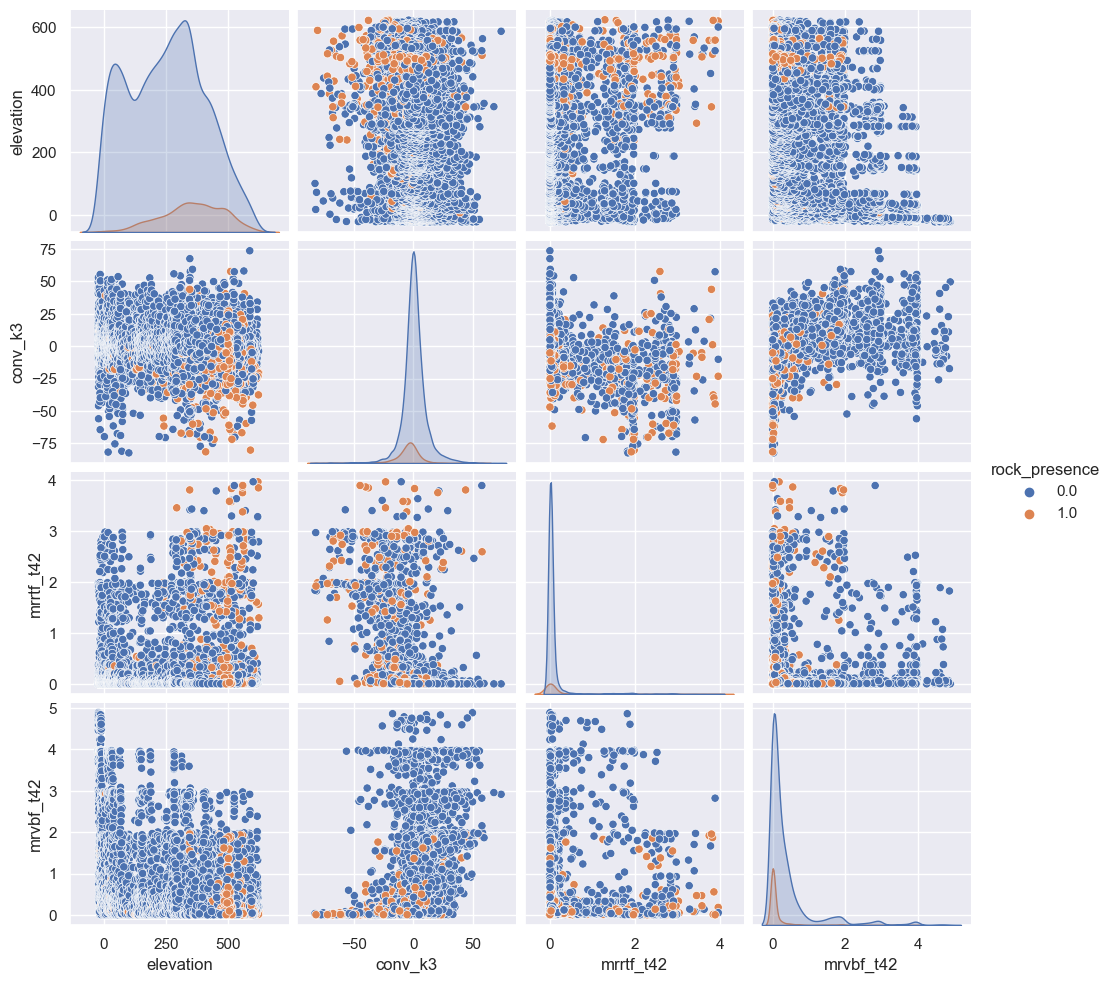

In [11]:
#SELECTED_FEATURES = ['rock_presence','elevation', 'conv_k3', 'mrrtf_t42', 'mrvbf_t42', 'fishersK_k3', 'grass_pcurve', 'grass_slope', 'grass_tcurve', 'stdDev_k3', 'topoRoughIdx_k3', 'topoWetIdx', 'vector_strength_k3']
#SELECTED_FEATURES = ['rock_presence','elevation', 'conv_k3', 'mrrtf_t42', 'mrvbf_t42', 'fishersK_k3', 'grass_slope', 'stdDev_k3', 'topoWetIdx']
SELECTED_FEATURES = ['rock_presence','elevation', 'conv_k3', 'mrrtf_t42', 'mrvbf_t42']

sn.pairplot(features[SELECTED_FEATURES],hue='rock_presence')

In [12]:
features[DEPENDENT_COLUMN]=features[DEPENDENT_COLUMN].astype('category')

if (RESCALE_DATA):
    features = data_processing.rescale_data(features, DEPENDENT_COLUMN, X_COL, Y_COL)

---
**Generate test/train dataset splits**

Based on prior defined parameters, we'll now separate the wrangled dataframe into test and train portions.


In [13]:
# Saving feature names for later use
feature_list = list(features.columns)
feature_types = features.dtypes

#~~~~~~~~~~~~~~
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels =data_processing.t_t_split(features, TEST_PROP, DEPENDENT_COLUMN, False)

compare_features=test_features # keep these for later - a copy of the test_features that won;t have any columns removed

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

assert train_features.shape[0] != test_features.shape[0] # should be different
assert train_features.shape[0] == train_labels.shape[0] # should be the same length (1 label for each row) 

train = train_features
test = test_features

for f in TRAIN_DATA_DROPS:
    train=train.drop(f, axis = 1)
    #test=test.drop(f, axis = 1)

train_features__list_post_drop = list(train.columns)
test_features__list_post_drop = list(test.columns)

Training Features Shape: (16678, 34)
Training Labels Shape: (16678,)
Testing Features Shape: (4170, 34)
Testing Labels Shape: (4170,)


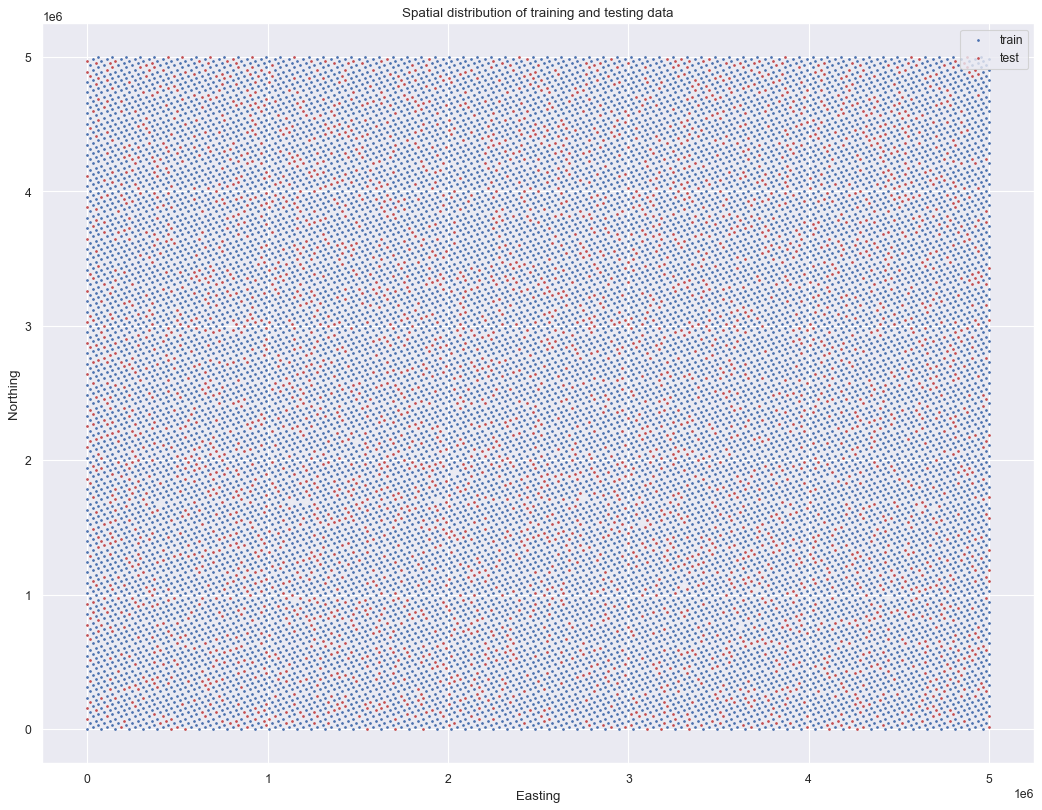

In [14]:
#plot train test distribution
plotting.plot_data_points(train_features,
                          test_features,
                          X_COL,
                          Y_COL,
                          'train',
                          'test',
                          'Spatial distribution of training and testing data')

In [15]:
#class rescaling
test = data_processing.class_rescale(test, TEST_SCALE_METHOD, DEPENDENT_COLUMN)
train = data_processing.class_rescale(train, TRAIN_SCALE_METHOD, DEPENDENT_COLUMN)

## Train and save model

In [16]:
# Start h2o session
try:
    h2o.cluster().shutdown()
except:
    print("No session to shutdown...")
h2o.init()

# CReate h2o objects of our test/train datasets
hf_train, hf_test = h2o_rf.create_h2o_sets(train, test, DEPENDENT_COLUMN)
rf = h2o_rf.train_h2o_rf(hf_train, hf_test, RF_PARAMS , DEPENDENT_COLUMN, ignore=[])

saved_model=h2o.save_model(rf, MODEL_OPATH, force=True)

print("*******\nModel saved: %s" %MODEL_OPATH)

#save the test set for future analysis
h2o.h2o.export_file(
  hf_test,
  "%s/test-%s" %(MODEL_OPATH, rf.model_id),
  force = True
)

#save the test set for future analysis
h2o.h2o.export_file(
  hf_train,
  "%s/train-%s" %(MODEL_OPATH, rf.model_id),
  force = True
)

rf.model_performance()


No session to shutdown...
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from C:\Users\chrwil\AppData\Local\Continuum\anaconda3\envs\py38_rf-classifier_windows\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\chrwil\AppData\Local\Temp\tmpt7mg4yh0
  JVM stdout: C:\Users\chrwil\AppData\Local\Temp\tmpt7mg4yh0\h2o_chrwil_started_from_python.out
  JVM stderr: C:\Users\chrwil\AppData\Local\Temp\tmpt7mg4yh0\h2o_chrwil_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Europe/London
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.2
H2O_cluster_version_age:    9 months and 24 days !!!
H2O_cluster_name:           H2O_from_python_chrwil_2n1ewk
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.524 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.15 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
*******
Model saved: RFClassifier_h2o
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07871901751772953
RMSE: 0.28056909579946526
LogLoss: 0.2750067064788537
Mean Per-Class Error: 0.08854860186418109
AUC: 0.9661657071530015
AUCPR: 0.9591101159733293
Gini: 0.9323314143060031

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49282746766345925
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      13173  1847   0.123    (1847.0/15020.0)
1      813    14207  0.0541   (813.0/15020.0)
Total  13986  16054  0.0885   (2660.0/30040.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492827     0.914398  207
max f2                       0.387169     0.948695  244
max f0point5                 0.60078      0.908909  168
max accuracy                 0.492827     0.911451  207
max precision                0.995161     1         0
max recall                   0.145753     1         331
max specificity              0.995161     1         0
max absolute_mcc             0.492827     0.82486   207
max min_per_class_accuracy   0.559899     0.905526  182
max mean_per_class_accuracy  0.492827     0.911451  207
max tns                      0.995161     15020     0
max fns                      0.995161     14966     0
max fps                      0.000736577  15020     399
max tps                      0.145753     15020     331
max tnr                      0.995161     1         0
max fnr                      0.995161     0.996405  0
max fpr                      0.000736577  1         399
max tpr                      0.145753     1         331

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.17 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01002                     0.98611            2           2                  1                0.990099   1                           0.990099            0.0200399       0.0200399                  100       100                0.0200399
2        0.0200067                   0.981015           1.98        1.99002            0.99             0.983427   0.995008                    0.986769            0.0197736       0.0398136                  98        99.0017            0.0396138
3        0.0300266                   0.976168           1.98671     1.98891            0.993355         0.97869    0.994457                    0.984073            0.0199068       0.0597204                  98.6711   98.8914            0.0593875
4        0.0400133                   0.970237           2           1.99168            1                0.973167   0.99584                     0.981351            0.0199734       0.0796937                  100       99.1681            0.0793609
5        0.05                        0.964119           1.98        1.98935            0.99             0.967122   0.994674                    0.978509            0.0197736       0.0994674                  98        98.9348            0.0989348
6        0.1                         0.937437           1.97603     1.98269            0.988016         0.950732   0.991345                    0.96462             0.0988016       0.198269                   97.6032   98.269             0.196538
7        0.15                        0.907008           1.9534      1.97292            0.976698         0.921937   0.986462                    0.950393            0.0976698       0.295939                   95.3395   97.2925        

---

**Test Model**

We will now predict values using our trained model using our test set to evaluate model performance.

The most important things to report regardnig model performance are as follows:

+ *Precision* – What percent of your predictions were correct?
+ *Recall* (or *sensitivity*) – What percent of the positive cases did you catch? 
+ *F1 score* – What percent of positive predictions were correct? 
+ A confusion matrix - display of true/false positive/negative predictions

There are many other metrics that can be reported too including:

+ *FN* – False Negatives
+ RMSE 
+ etc.

Info on interpreting model perfomance here: 

+ https://h2o.ai/wiki/confusion-matrix/
+ https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html

In [17]:
# Model performance
performance = rf.model_performance(test_data=hf_test)
print(performance) # all of it

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.10688413864936577
RMSE: 0.3269313974664498
LogLoss: 0.33848507876060013
Mean Per-Class Error: 0.2452006321462235
AUC: 0.8764116352813409
AUCPR: 0.5072565394545263
Gini: 0.7528232705626818

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5915755598598568
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      3402  352  0.0938   (352.0/3754.0)
1      165   251  0.3966   (165.0/416.0)
Total  3567  603  0.124    (517.0/4170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.591576     0.49264   118
max f2                       0.401179     0.596822  185
max f0point5                 0.800943     0.557692  49
max accuracy                 0.842015     0.918225  37
max precision                0.99079      1         0
max recall            

Model perfomance can also be assessed using scikit-learn.

This requires us to specifically apply the model to our test dataset too.

Essentially, we're going to now specifically use our trained model to create some **predictions** using our **test** dataset - the difference bewteen this prediction and using other data, is that we have labels to compare to with our testing data! 

Info on reading the classification report here: https://muthu.co/understanding-the-classification-report-in-sklearn/ (you call this using a wrapper here: `h2o_rf.get_classification_report`)


In [18]:
pred=None
pred = rf.predict(hf_test)
y_pred, y_true = h2o_rf.get_classification_report(pred, hf_test, DEPENDENT_COLUMN)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3754
           1       0.36      0.70      0.48       416

    accuracy                           0.85      4170
   macro avg       0.66      0.78      0.69      4170
weighted avg       0.90      0.85      0.87      4170



We will now plot a confusion matrix, considering our predicted outputs and known input classifications:

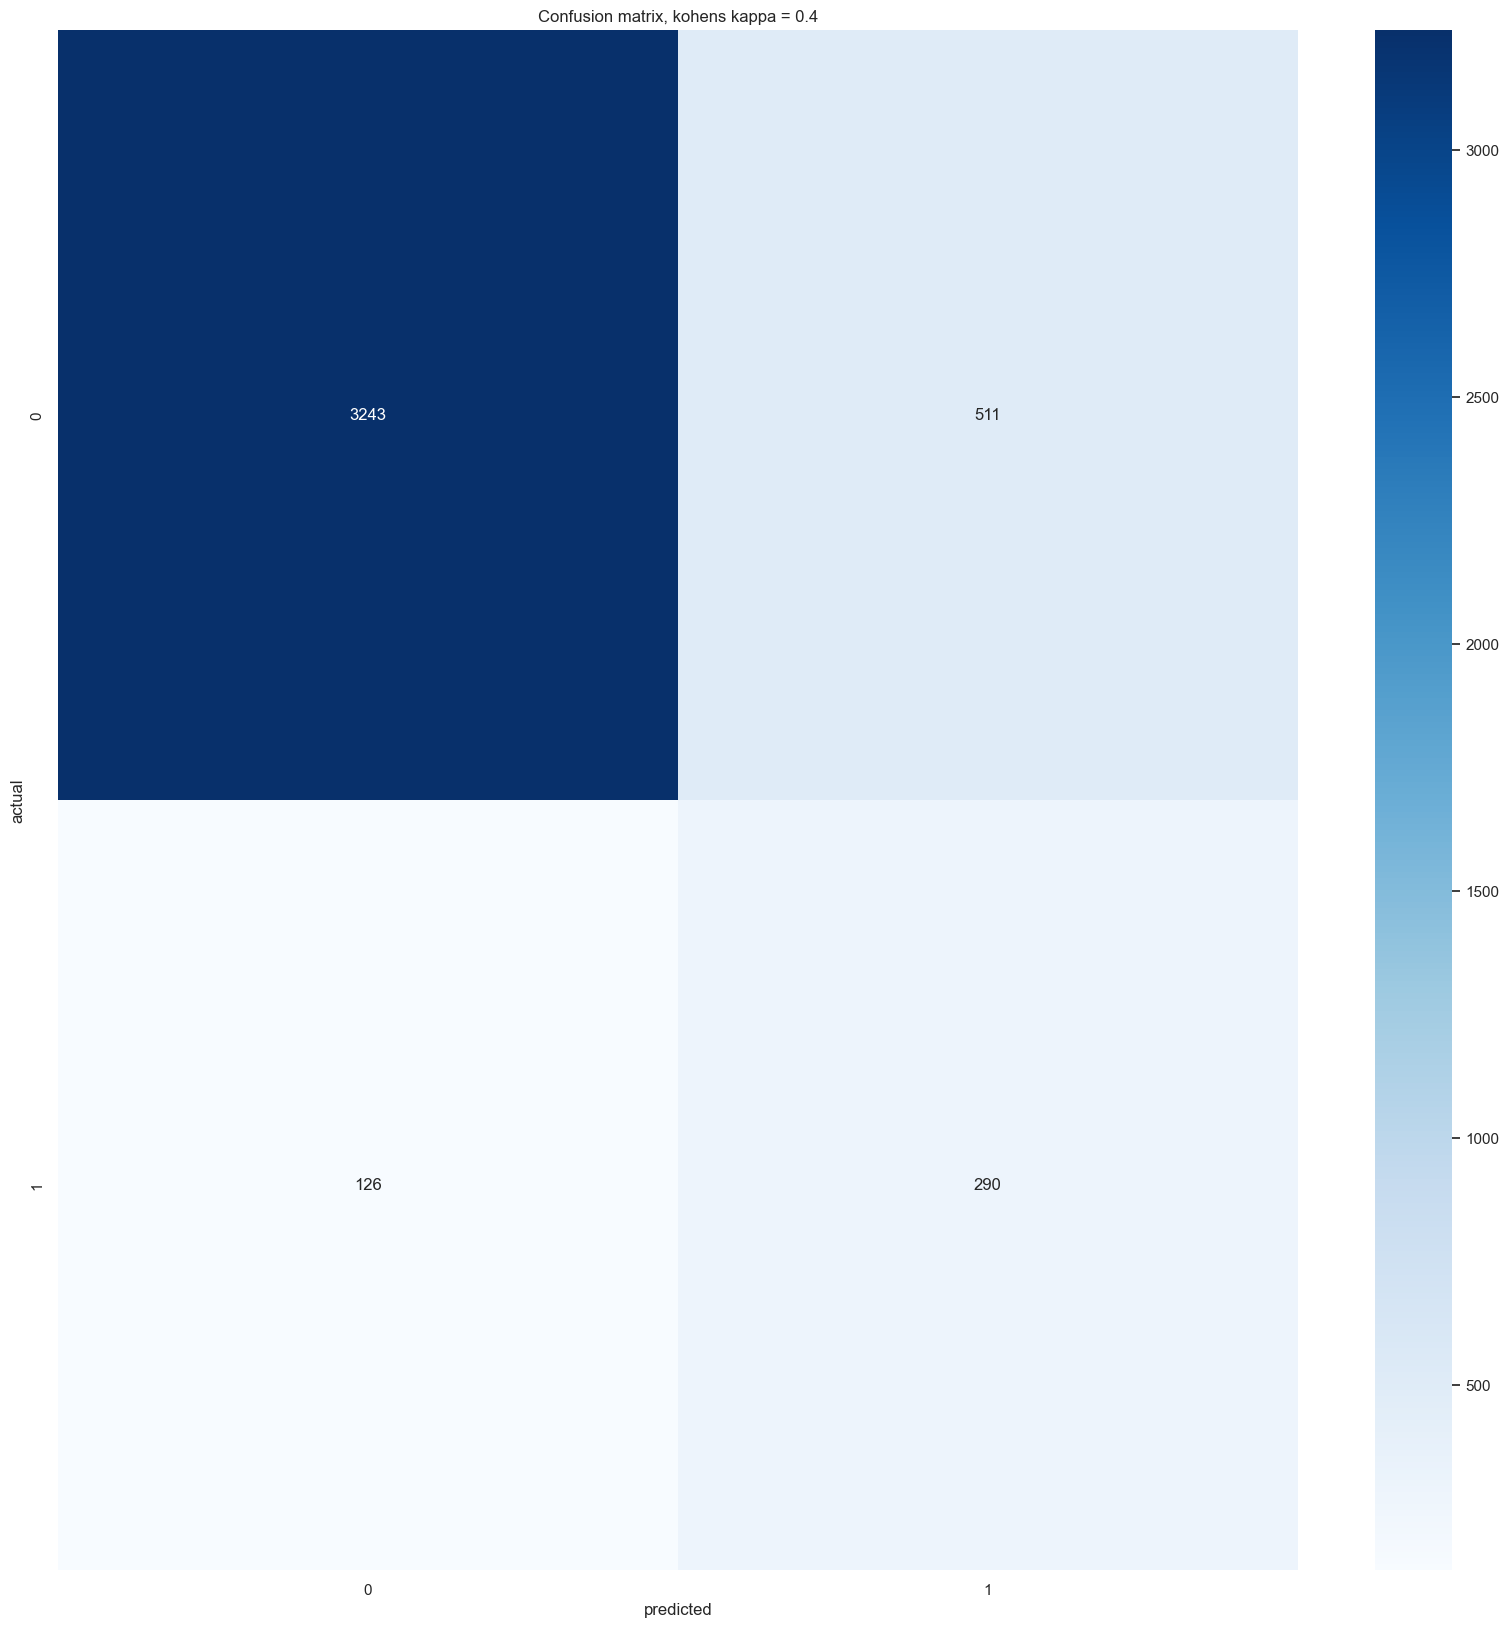

In [19]:
y_pred_binary = y_pred["predict"].values
y_true_binary = y_true[DEPENDENT_COLUMN].values

k = cohen_kappa_score(y_true_binary, y_pred_binary)
h2o_rf.plot_confusion_matrix(y_true_binary, y_pred_binary, 'Confusion matrix, kohens kappa = ' + str(round(k,2)))


Now we'll find the Receiver operating characteristic (ROC)details.

See here for info: 

+ https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
+ https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [20]:
# Append the prediction and p1 probabilities to our test dataframe (so we can look at things together)
test_df=hf_test.as_data_frame() # make local object from h2o - easier to work with
pred=pred.as_data_frame() # make local object from h2o - easier to work with

test_df['predict'] = pred['predict']
test_df['p1'] = pred['p1']
#print(test_df.columns)

Now calculate ROC curve metrics...

Read more on the roc curve - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [21]:
fp, tp, thresh = metrics.roc_curve(test_df[DEPENDENT_COLUMN].astype(int),test_df['p1'])
print("Threshold:", thresh)
print("False positives:", fp)
print("True positives:", tp)

Threshold: [1.99078998e+00 9.90789983e-01 9.84075214e-01 9.78068252e-01
 9.76786437e-01 9.70817952e-01 9.70353088e-01 9.62258126e-01
 9.61078176e-01 9.50814634e-01 9.50492990e-01 9.48253719e-01
 9.43335998e-01 9.40102813e-01 9.40041560e-01 9.31403903e-01
 9.30849686e-01 9.26055576e-01 9.24886346e-01 9.22029114e-01
 9.21381596e-01 9.21201075e-01 9.21021831e-01 9.19873518e-01
 9.18830891e-01 9.15435865e-01 9.15051024e-01 9.08303106e-01
 9.05757888e-01 8.99561566e-01 8.96722592e-01 8.95287805e-01
 8.94468863e-01 8.93814823e-01 8.93313193e-01 8.92971915e-01
 8.88374949e-01 8.83720128e-01 8.83686508e-01 8.80557461e-01
 8.79630686e-01 8.78215900e-01 8.76039340e-01 8.74200602e-01
 8.72207742e-01 8.70401012e-01 8.70034525e-01 8.65925376e-01
 8.63869908e-01 8.63220083e-01 8.62085951e-01 8.59344529e-01
 8.57793190e-01 8.52079529e-01 8.51285711e-01 8.46293097e-01
 8.45519063e-01 8.43002042e-01 8.42825967e-01 8.42301968e-01
 8.41769728e-01 8.41415693e-01 8.37302324e-01 8.35489529e-01
 8.27755071e-

... and look at a summary of our predicted outputs to see what our percentage predictions actually look like for the 2 classes:

+ p0 - prediction value of a "0"
+ p1 - prediction value of a "1"

In [22]:
test_df.predict
pred.head()

predict        p0        p1
0        1  0.480537  0.519463
1        1  0.059897  0.940103
2        1  0.077971  0.922029
3        0  0.535501  0.464499
4        1  0.329314  0.670686

We'll now plot the Receiver Operator Curve (ROC) plot - more on these here: https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/

Note that the ROC (and resulting area under the curve - AUC) was also calculated earlier using `rf.model_performance`

As this is a binary problem, the random chance level displayed on the ROC plot (the dashed line) will have an AUC of 50% - i.e. as it is either a 0 or a 1, there is a 50% random chance of the prediction being correct.

Youden's J can also be calcuated and used here - this is the value against which predictions can be compared for binary classifications:

- *> threshold* = p1
- *< threshold* = p0

This then defines what counts as true/false posities and negatives, and has a direct impact on the resulting ROC etc


Info: https://en.wikipedia.org/wiki/Youden%27s_J_statistic

In [23]:
#Youden's J statistic to decide best threshold
J = tp-fp
index = np.argmax(J)
best_threshold = thresh[index]
best_threshold
print(best_threshold)

0.4048227892036032


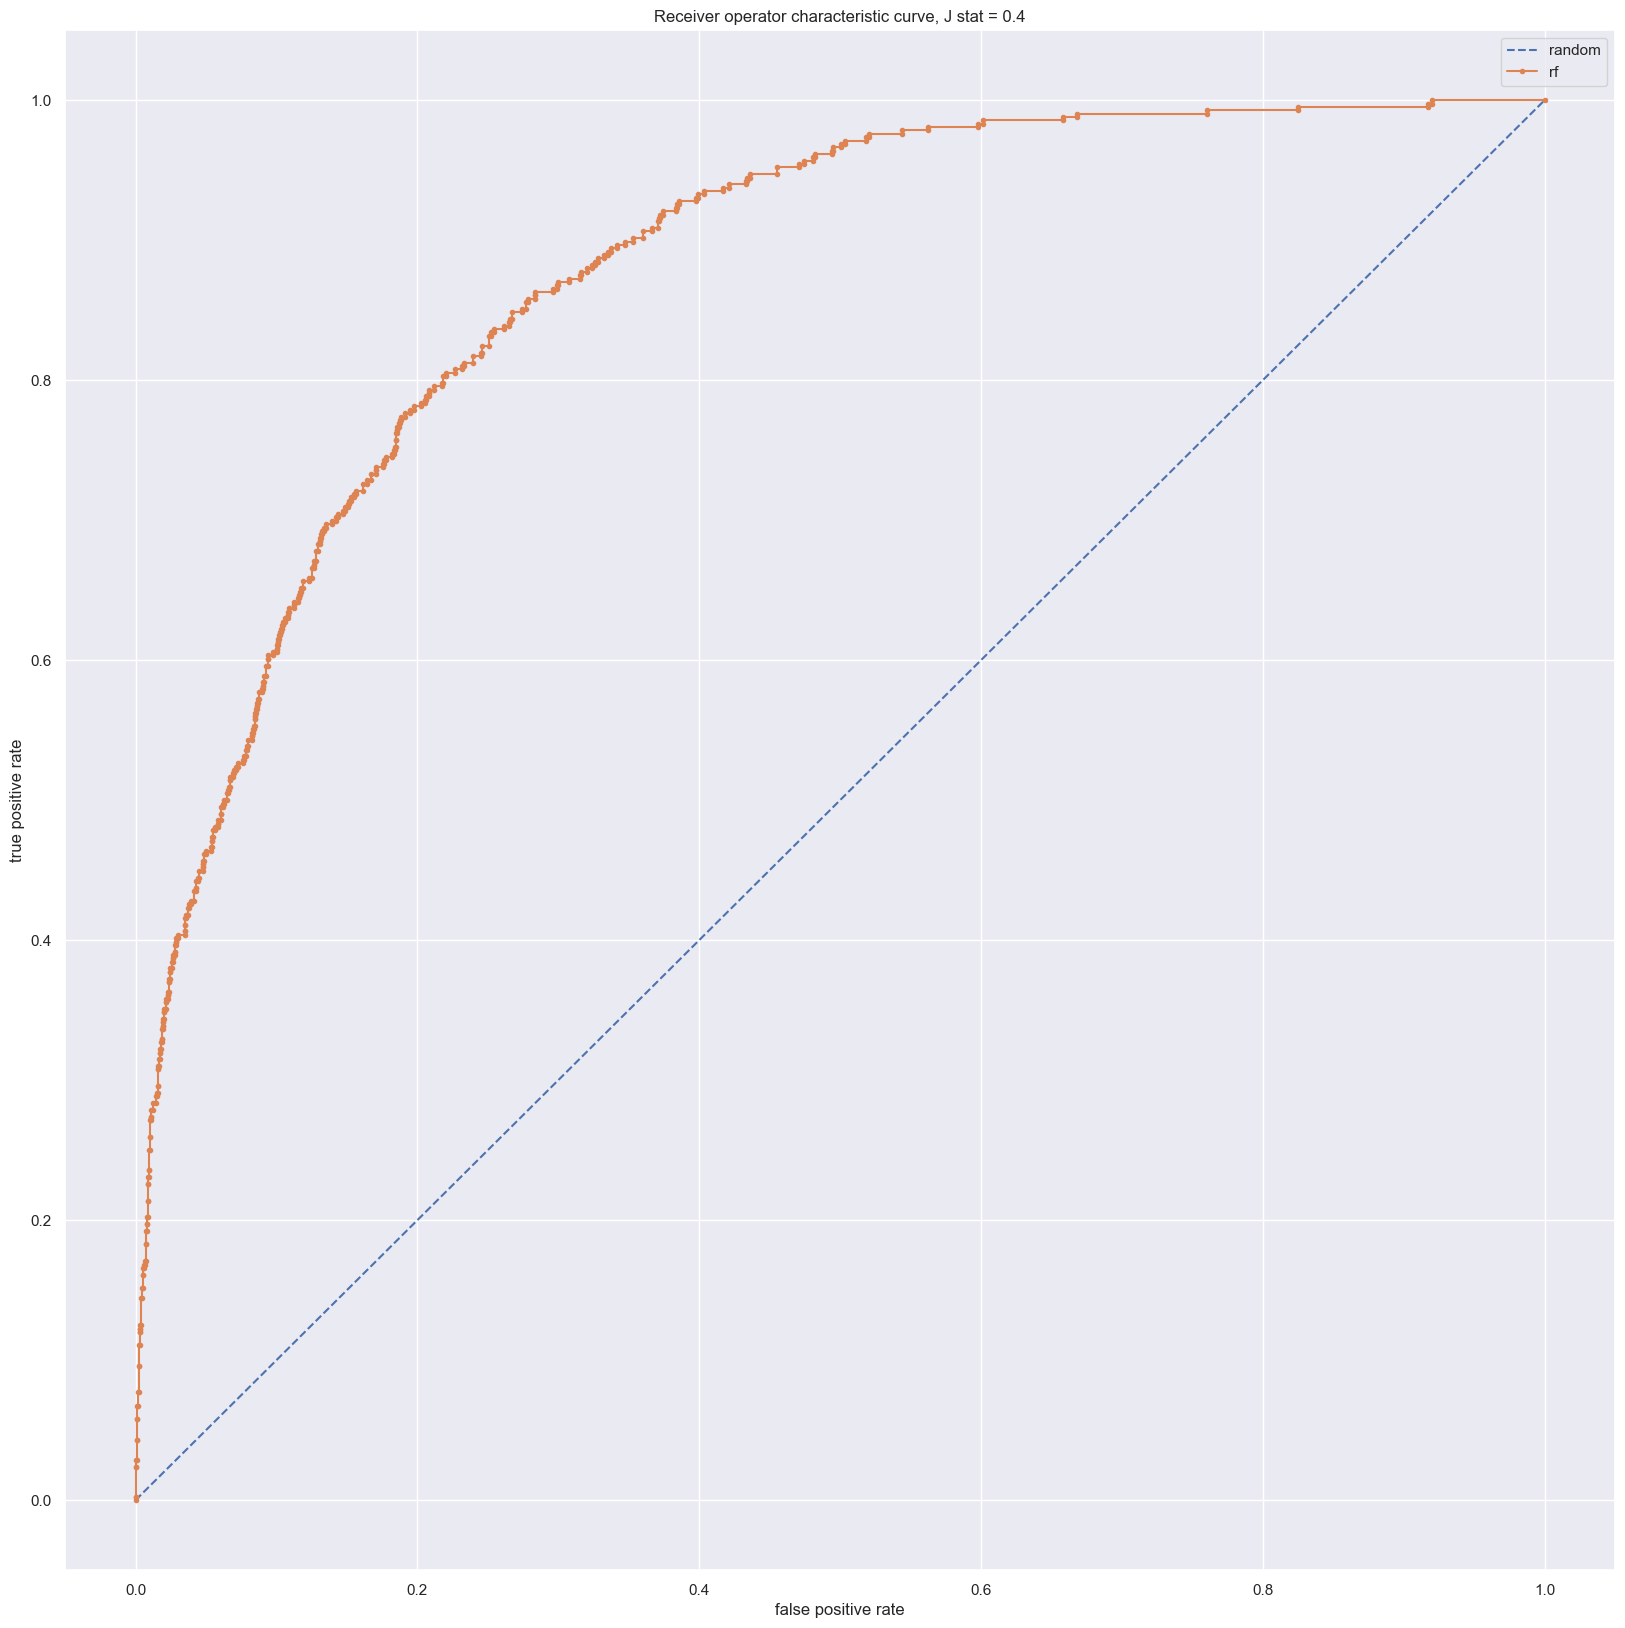

In [24]:
plt.plot([0,1],[0,1], linestyle='--', label='random')
plt.plot(fp,tp,marker='.',label='rf')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver operator characteristic curve, J stat = ' +str(round(best_threshold, 2)))
plt.legend()
plt.show()

We can also look at variable importance

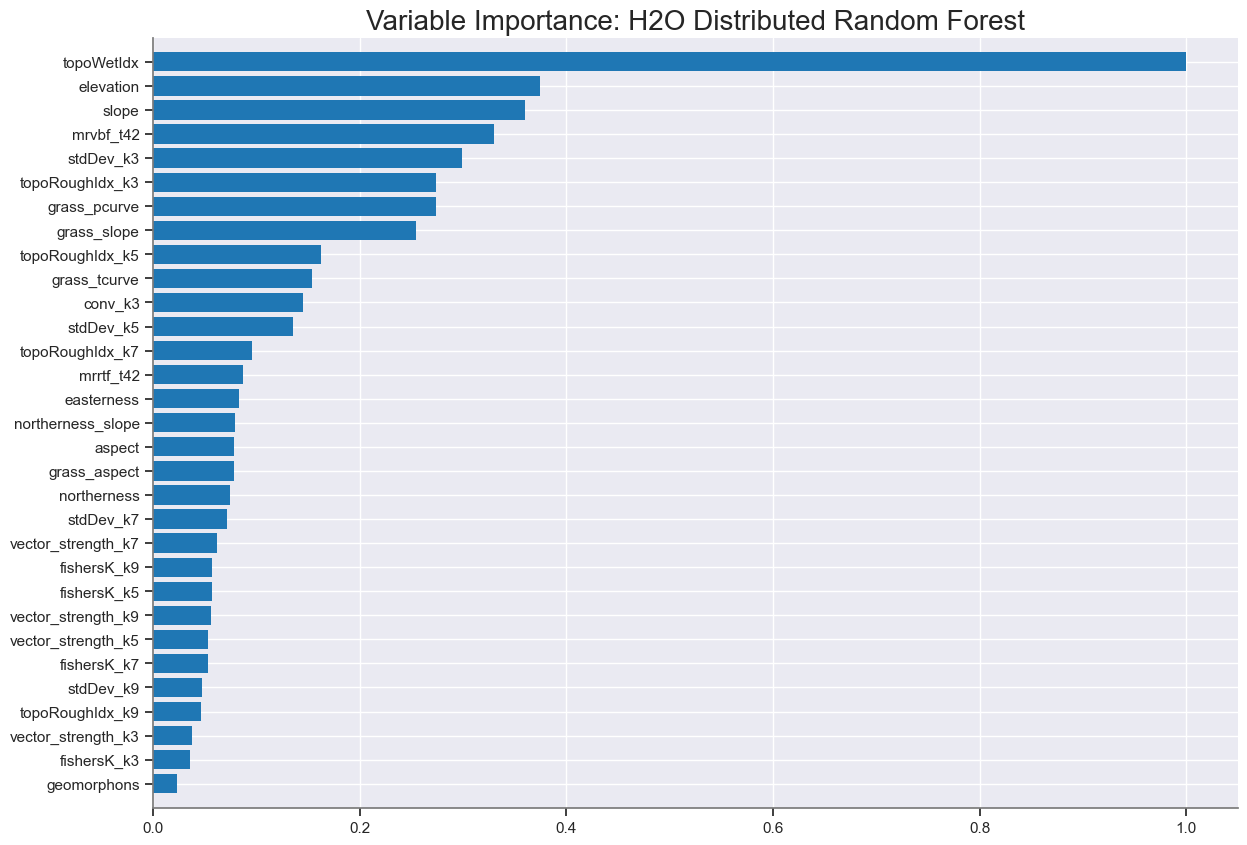

<Figure size 2000x2000 with 0 Axes>

In [25]:
rf.varimp(use_pandas=True)
rf.varimp_plot(num_of_features=rf.varimp(use_pandas=True).shape[0]);

We will now create spatial plots of the predictions, as well as positive and negative predictons (true and false cases indciated)

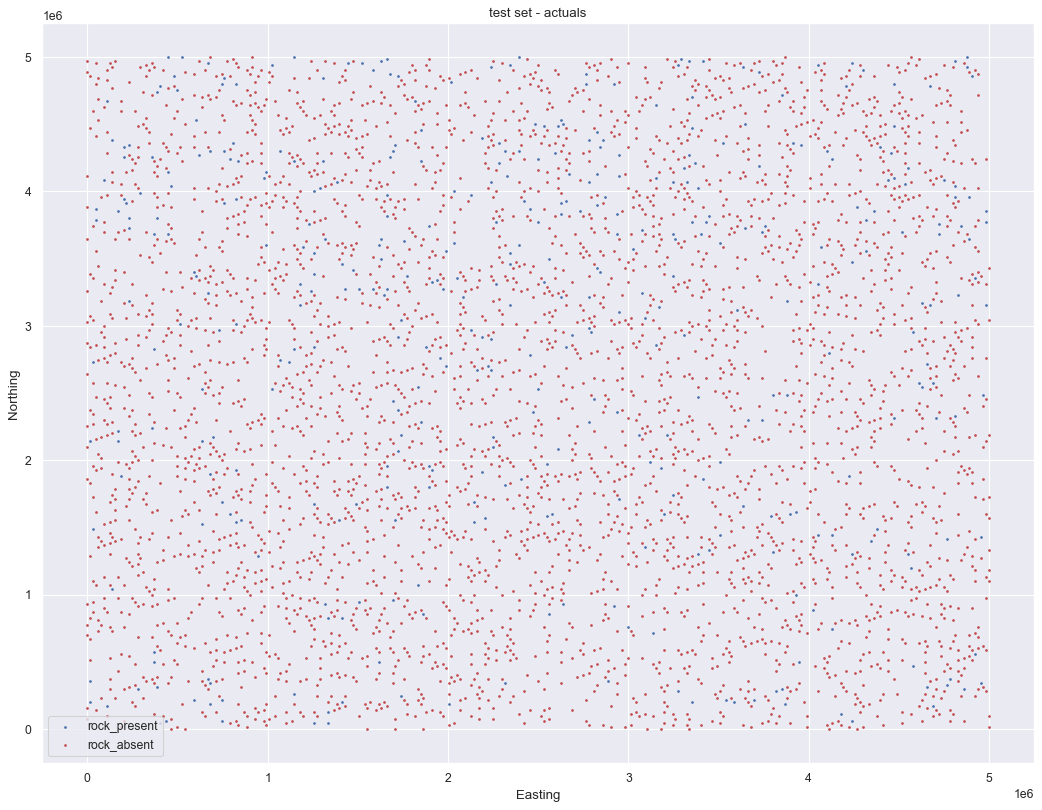

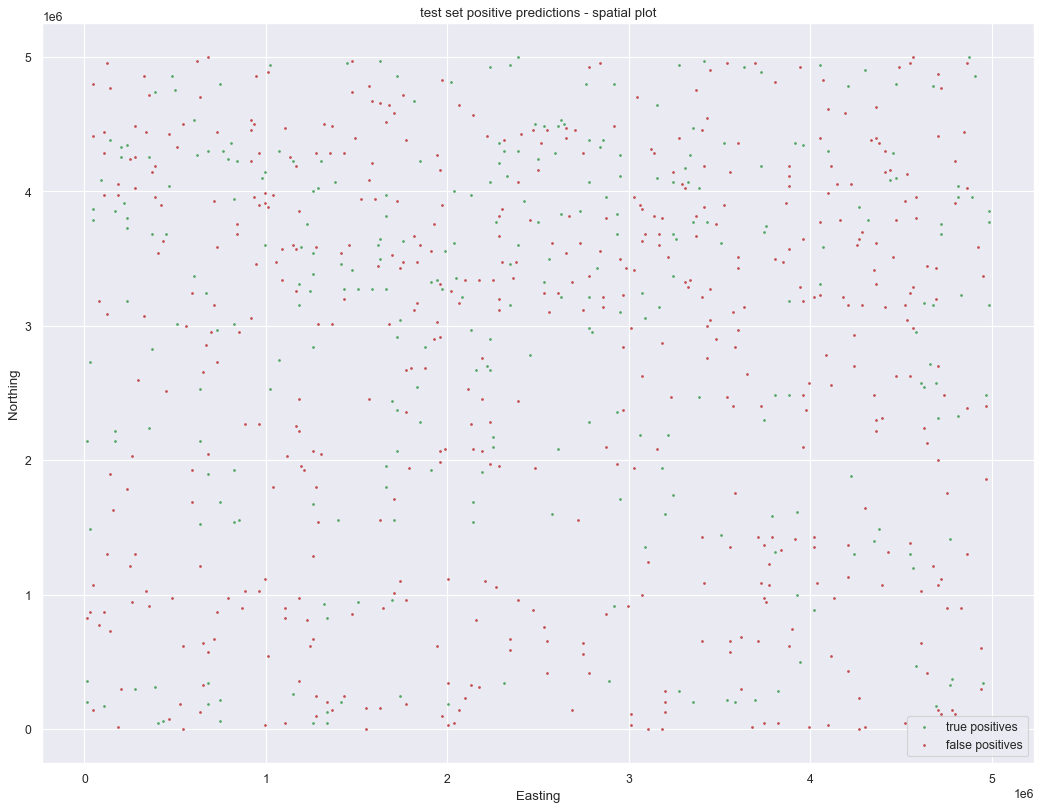

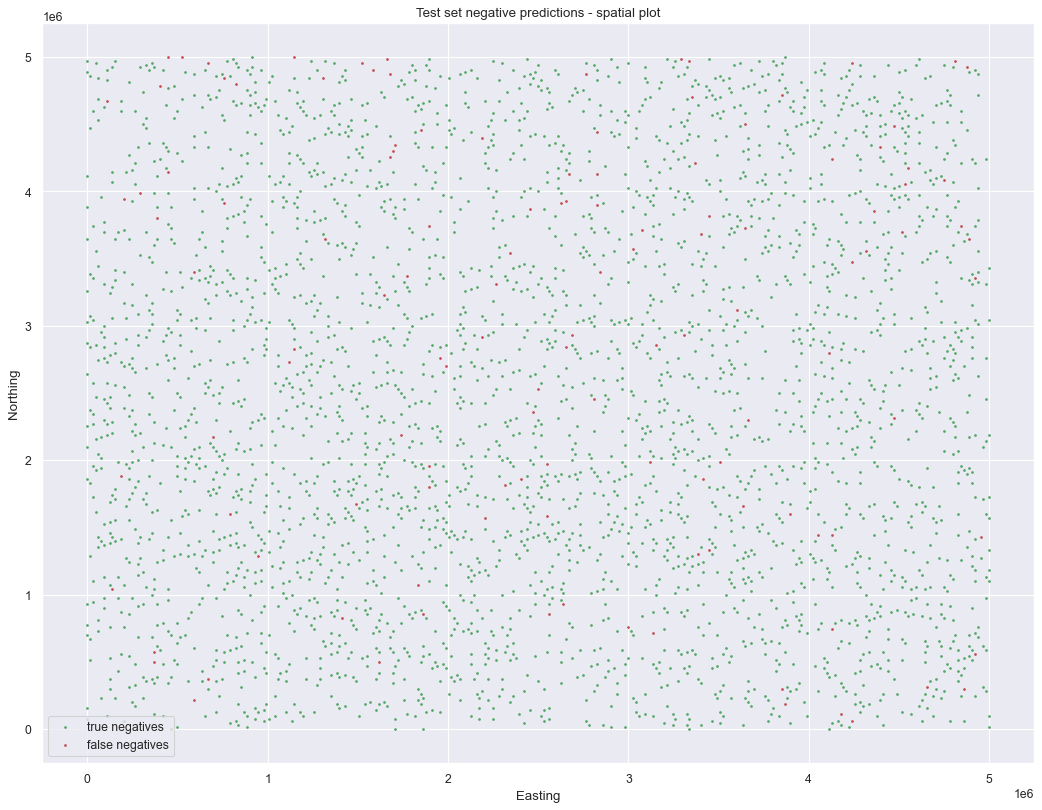

In [26]:
plot_df = test_df

true_pos = plot_df[(plot_df['predict'] == 1) & (plot_df[DEPENDENT_COLUMN] == 1)]
true_neg = plot_df[(plot_df['predict'] == 0) & (plot_df[DEPENDENT_COLUMN] == 0)]
false_pos = plot_df[(plot_df['predict'] == 1) & (plot_df[DEPENDENT_COLUMN] == 0)]
false_neg = plot_df[(plot_df['predict'] == 0) & (plot_df[DEPENDENT_COLUMN] == 1)]

plotting.plot_data_points(plot_df[plot_df[DEPENDENT_COLUMN] == 1],
                          plot_df[plot_df[DEPENDENT_COLUMN] == 0],
                          X_COL,
                          Y_COL,
                          'rock_present',
                          'rock_absent',
                          'test set - actuals')


plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(true_pos[X_COL], true_pos[Y_COL], c = 'g',s = 2, label = 'true positives')
plt.scatter(false_pos[X_COL], false_pos[Y_COL], c = 'r',s = 2, label = 'false positives')
plt.title('test set positive predictions - spatial plot' )
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()


plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(true_neg[X_COL], true_neg[Y_COL], c='g', s=2, label='true negatives')
plt.scatter(false_neg[X_COL], false_neg[Y_COL], c='r', s=2, label='false negatives')
plt.title('Test set negative predictions - spatial plot' )
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

